In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob 

import pandas as pd

from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

import matplotx
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotx
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])

%matplotlib inline

## Load results

In [3]:
all_out = glob("out/**/*.pkl")

In [4]:
all_out = [load_pickle(p) for p in all_out]

In [5]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out: 
    try:
        res = {
            'train_size': out['train_size'],
            'frac_valid': out['frac_valid'],
            'accuracy': out['accuracy'],
            'f1_macro': out['f1_macro'],
            'f1_micro': out['f1_micro'],
            'kappa': out['kappa'],
            "num_classes": out['num_classes'],
            "representation": out['representation']
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        'train_size': out['train_size'], 
        'accuracy': out['xgboost_baseline']['accuracy'], 
        'f1_macro': out['xgboost_baseline']['f1_macro'],
        'f1_micro': out['xgboost_baseline']['f1_micro'],
        'kappa': out['xgboost_baseline']['kappa'],
        "num_classes": out['num_classes']
    }

    tabpfn_res = {
        'train_size': out['train_size'], 
        'accuracy': out['tabpfn_baseline']['accuracy'], 
        'f1_macro': out['tabpfn_baseline']['f1_macro'],
        'f1_micro': out['tabpfn_baseline']['f1_micro'],
        'kappa': out['tabpfn_baseline']['kappa'],
        "num_classes": out['num_classes']
    }

   
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [6]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [7]:
grouped_res = res.groupby(['num_classes', "representation", 'train_size']).agg(['mean', 'std', 'count', sem])

In [8]:
grouped_xgboost_res = xgboost_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std', sem])

In [9]:
grouped_tabpfn_res = tabpfn_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std', sem])

In [10]:
grouped_res.loc[2,:]

frac_valid                            accuracy  \
                                mean       std count       sem      mean   
representation train_size                                                  
InChI          10           1.000000  0.000000     5  0.000000  0.575200   
               50           1.000000  0.000000     6  0.000000  0.629333   
               100          1.000000  0.000000     5  0.000000  0.648800   
               200          1.000000  0.000000     6  0.000000  0.666667   
               500          1.000000  0.000000     6  0.000000  0.692000   
SELFIES        10           1.000000  0.000000     5  0.000000  0.532000   
               50           1.000000  0.000000     6  0.000000  0.588667   
               100          1.000000  0.000000     5  0.000000  0.625600   
               200          1.000000  0.000000     6  0.000000  0.662000   
               500          1.000000  0.000000     6  0.000000  0.698667   
SMILES         10           1.000000  0.000000     6  0.000000  0.556000   
               50           1.000000  0.000000     6  0.000000  0.604667   
               100          1.000000  0.000000     6  0.000000  0.656667   
               200          1.000000  0.000000     6  0.000000  0.677333   
               500          0.999333  0.001633     6  0.000667  0.718487   

                                                     f1_macro                  \
                                std count       sem      mean       std count   
representation train_size                                                       
InChI          10          0.035259     5  0.015768  0.545902  0.061179     5   
               50          0.031665     6  0.012927  0.627607  0.031263     6   
               100         0.030384     5  0.013588  0.646964  0.030383     5   
               200         0.039165     6  0.015989  0.665562  0.039288     6   
               500         0.021317     6  0.008702  0.691364  0.021451     6   
SELFIES        10          0.052839     5  0.023630  0.497670  0.099056     5   
               50          0.048492     6  0.019797  0.584492  0.052911     6   
               100         0.024755     5  0.011071  0.623091  0.024774     5   
               200         0.027568     6  0.011255  0.659538  0.028588     6   
               500         0.036719     6  0.014990  0.698502  0.036773     6   
SMILES         10          0.041569     6  0.016971  0.506474  0.088092     6   
               50          0.052728     6  0.021526  0.602294  0.054599     6   
               100         0.035001     6  0.014289  0.653083  0.036228     6   
               200         0.020656     6  0.008433  0.675489  0.020263     6   
               500         0.018556     6  0.007575  0.718355  0.018549     6   

                                     f1_micro                            \
                                sem      mean       std count       sem   
representation train_size                                                 
InChI          10          0.027360  0.575200  0.035259     5  0.015768   
               50          0.012763  0.629333  0.031665     6  0.012927   
               100         0.013588  0.648800  0.030384     5  0.013588   
               200         0.016039  0.666667  0.039165     6  0.015989   
               500         0.008758  0.692000  0.021317     6  0.008702   
SELFIES        10          0.044299  0.532000  0.052839     5  0.023630   
               50          0.021601  0.588667  0.048492     6  0.019797   
               100         0.011079  0.625600  0.024755     5  0.011071   
               200         0.011671  0.662000  0.027568     6  0.011255   
               500         0.015012  0.698667  0.036719     6  0.014990   
SMILES         10          0.035963  0.556000  0.041569     6  0.016971   
               50          0.022290  0.604667  0.052728     6  0.021526   
               100         0.014790  0.656667  0.035001     6  0.014289  

In [11]:
grouped_tabpfn_res

accuracy                      f1_macro            \
                            mean       std       sem      mean       std   
num_classes train_size                                                     
2           10          0.558105  0.028825  0.006613  0.549658  0.036467   
            50          0.560571  0.029183  0.006368  0.557362  0.032043   
            100         0.575579  0.024941  0.005722  0.574881  0.024805   
            200         0.612571  0.026055  0.005686  0.612282  0.026108   
            500         0.616000  0.042590  0.009523  0.614904  0.043483   
5           10          0.214667  0.028084  0.006619  0.202640  0.033430   
            50          0.242000  0.024088  0.005678  0.234128  0.020855   
            100         0.259333  0.036616  0.008630  0.237527  0.041268   
            200         0.292000  0.028910  0.006814  0.267240  0.031886   
            500         0.342667  0.026426  0.006229  0.311384  0.024345   

                                  f1_micro                         kappa  \
                             sem      mean       std       sem      mean   
num_classes train_size                                                     
2           10          0.008366  0.558105  0.028825  0.006613  0.116211   
            50          0.006992  0.560571  0.029183  0.006368  0.121143   
            100         0.005691  0.575579  0.024941  0.005722  0.151158   
            200         0.005697  0.612571  0.026055  0.005686  0.225143   
            500         0.009723  0.616000  0.042590  0.009523  0.232000   
5           10          0.007880  0.214667  0.028084  0.006619  0.018333   
            50          0.004916  0.242000  0.024088  0.005678  0.052500   
            100         0.009727  0.259333  0.036616  0.008630  0.074167   
            200         0.007516  0.292000  0.028910  0.006814  0.115000   
            500         0.005738  0.342667  0.026426  0.006229  0.178333   

                                            
                             std       sem  
num_classes train_size                      
2           10          0.057650  0.013226  
            50          0.058366  0.012737  
            100         0.049881  0.011444  
            200         0.052110  0.011371  
            500         0.085180  0.019047  
5           10          0.035105  0.008274  
            50          0.030110  0.007097  
            100         0.045770  0.010788  
            200         0.036137  0.008518  
            500         0.033033  0.007786

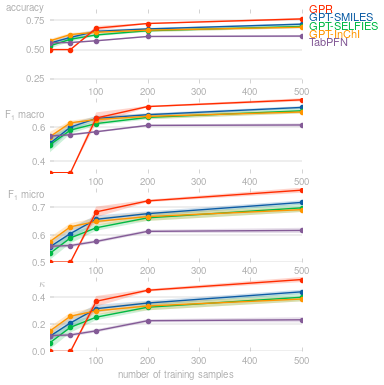

In [12]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
        ax[i].plot(
            grouped_res.loc[2, 'SMILES', :].index,
            grouped_res.loc[2, 'SMILES', :][metric]['mean'],
            marker='o',
            label='GPT-SMILES',
        )
        ax[i].fill_between(
            grouped_res.loc[2, 'SMILES', :].index,
            grouped_res.loc[2, 'SMILES', :][metric]['mean'] - grouped_res.loc[2, 'SMILES', :][metric]['sem'],
            grouped_res.loc[2, 'SMILES', :][metric]['mean'] + grouped_res.loc[2, 'SMILES', :][metric]['sem'],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[2, 'SELFIES', :].index,
            grouped_res.loc[2, 'SELFIES', :][metric]['mean'],
            marker='o',
            label='GPT-SELFIES',
        )
        ax[i].fill_between(
            grouped_res.loc[2, 'SELFIES', :].index,
            grouped_res.loc[2, 'SELFIES', :][metric]['mean'] - grouped_res.loc[2, 'SELFIES', :][metric]['sem'],
            grouped_res.loc[2, 'SELFIES', :][metric]['mean'] + grouped_res.loc[2, 'SELFIES', :][metric]['sem'],
            alpha=0.2,
        )


        ax[i].plot(
            grouped_res.loc[2, 'InChI', :].index,
            grouped_res.loc[2, 'InChI', :][metric]['mean'],
            marker='o',
            label='GPT-InChI',
        )
        ax[i].fill_between(
            grouped_res.loc[2, 'InChI', :].index,
            grouped_res.loc[2, 'InChI', :][metric]['mean'] - grouped_res.loc[2, 'InChI', :][metric]['sem'],
            grouped_res.loc[2, 'InChI', :][metric]['mean'] + grouped_res.loc[2, 'InChI', :][metric]['sem'],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[2,:].index,
            grouped_xgboost_res.loc[2,:][metric]['mean'],
            marker='o',
            label='GPR'
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[2,:].index,
            grouped_xgboost_res.loc[2,:][metric]['mean'] - grouped_xgboost_res.loc[2,:][metric]['sem'],
            grouped_xgboost_res.loc[2,:][metric]['mean'] + grouped_xgboost_res.loc[2,:][metric]['sem'],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[2,:].index,
            grouped_tabpfn_res.loc[2,:][metric]['mean'],
            marker='o',
            label='TabPFN'
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[2,:].index,
            grouped_tabpfn_res.loc[2,:][metric]['mean'] - grouped_tabpfn_res.loc[2,:][metric]['sem'],
            grouped_tabpfn_res.loc[2,:][metric]['mean'] + grouped_tabpfn_res.loc[2,:][metric]['sem'],
            alpha=0.2,
        )

    ax[-1].set_xlabel('number of training samples', labelpad=4)
    matplotx.line_labels(ax=ax[0], fontsize=8)
    ax[0].set_ylim(0.21,0.85)
    matplotx.ylabel_top('accuracy', ax=ax[0])
    matplotx.ylabel_top(r'F$_{1}$ macro', ax=ax[1])
    matplotx.ylabel_top(r'F$_{1}$ micro', ax=ax[2])
    matplotx.ylabel_top(r'$\kappa$', ax=ax[3])

    fig.savefig('bandgap-classification_results_2_class.pdf', bbox_inches='tight')

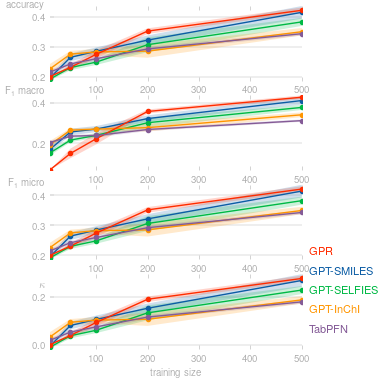

In [13]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
        ax[i].plot(
            grouped_res.loc[5, 'SMILES', :].index,
            grouped_res.loc[5, 'SMILES', :][metric]['mean'],
            marker='o',
            label='GPT-SMILES',
        )
        ax[i].fill_between(
            grouped_res.loc[5, 'SMILES', :].index,
            grouped_res.loc[5, 'SMILES', :][metric]['mean'] - grouped_res.loc[5, 'SMILES', :][metric]['sem'],
            grouped_res.loc[5, 'SMILES', :][metric]['mean'] + grouped_res.loc[5, 'SMILES', :][metric]['sem'],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[5, 'SELFIES', :].index,
            grouped_res.loc[5, 'SELFIES', :][metric]['mean'],
            marker='o',
            label='GPT-SELFIES',
        )
        ax[i].fill_between(
            grouped_res.loc[5, 'SELFIES', :].index,
            grouped_res.loc[5, 'SELFIES', :][metric]['mean'] - grouped_res.loc[5, 'SELFIES', :][metric]['sem'],
            grouped_res.loc[5, 'SELFIES', :][metric]['mean'] + grouped_res.loc[5, 'SELFIES', :][metric]['sem'],
            alpha=0.2,
        )


        ax[i].plot(
            grouped_res.loc[5, 'InChI', :].index,
            grouped_res.loc[5, 'InChI', :][metric]['mean'],
            marker='o',
            label='GPT-InChI',
        )
        ax[i].fill_between(
            grouped_res.loc[5, 'InChI', :].index,
            grouped_res.loc[5, 'InChI', :][metric]['mean'] - grouped_res.loc[5, 'InChI', :][metric]['sem'],
            grouped_res.loc[5, 'InChI', :][metric]['mean'] + grouped_res.loc[5, 'InChI', :][metric]['sem'],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[5,:].index,
            grouped_xgboost_res.loc[5,:][metric]['mean'],
            marker='o',
            label='GPR'
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[5,:].index,
            grouped_xgboost_res.loc[5,:][metric]['mean'] - grouped_xgboost_res.loc[5,:][metric]['sem'],
            grouped_xgboost_res.loc[5,:][metric]['mean'] + grouped_xgboost_res.loc[5,:][metric]['sem'],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[5,:].index,
            grouped_tabpfn_res.loc[5,:][metric]['mean'],
            marker='o',
            label='TabPFN'
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[5,:].index,
            grouped_tabpfn_res.loc[5,:][metric]['mean'] - grouped_tabpfn_res.loc[5,:][metric]['sem'],
            grouped_tabpfn_res.loc[5,:][metric]['mean'] + grouped_tabpfn_res.loc[5,:][metric]['sem'],
            alpha=0.2,
        )

    ax[-1].set_xlabel('training size', labelpad=4)
    matplotx.line_labels(ax[-1], fontsize=8)

    matplotx.ylabel_top('accuracy', ax=ax[0])
    matplotx.ylabel_top(r'F$_{1}$ macro', ax=ax[1])
    matplotx.ylabel_top(r'F$_{1}$ micro', ax=ax[2])
    matplotx.ylabel_top(r'$\kappa$', ax=ax[3])

    fig.savefig('bandgap-classification_results_5_class.pdf', bbox_inches='tight')